# Hands on Semantic Segmentation with U-Net

In [ ]:
!pip install -q tensorflow==2.10.0
!pip install -q keras==2.10.0
!pip install -U -q segmentation-models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.0/578.0 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 51.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 79.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 117.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 44.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 106.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-datasets 4.9.2 requires protobuf>=3.20, but you have protobuf 3.19.6 which is incompatible.
tensorflow-metadata 1.13.1 requires protobuf<5,>=3.20.3, but you have protobuf 3.19.6 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import PIL
from PIL import ImageOps
from IPython.display import Image, display
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from sklearn.model_selection import train_test_split

import segmentation_models as sm

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import load_img
import tensorflow.keras.layers as layers

from google.colab.patches import cv2_imshow


Segmentation Models: using `tf.keras` framework.


## Dataset

Fist, we download the dataset Oxford-IIIT pet dataset

In [ ]:
!curl -LO https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!curl -LO https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   350  100   350    0     0    520      0 --:--:-- --:--:-- --:--:--   519
100   185  100   185    0     0    138      0  0:00:01  0:00:01 --:--:--   138
100  755M  100  755M    0     0  20.8M      0  0:00:36  0:00:36 --:--:-- 22.5M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   355  100   355    0     0    503      0 --:--:-- --:--:-- --:--:--   502
100   185  100   185    0     0    135      0  0:00:01  0:00:01 --:--:--   135
100 18.2M  100 18.2M    0     0  5912k      0  0:00:03  0:00:03 --:--:-- 10.9M


Load our images using the following code:

In [36]:
input_dir = "images/" 
target_dir = "annotations/trimaps/"

img_size = (160, 160)
num_classes = 3
batch_size = 32

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 7390
images/Abyssinian_1.jpg | annotations/trimaps/Abyssinian_1.png
images/Abyssinian_10.jpg | annotations/trimaps/Abyssinian_10.png
images/Abyssinian_100.jpg | annotations/trimaps/Abyssinian_100.png
images/Abyssinian_101.jpg | annotations/trimaps/Abyssinian_101.png
images/Abyssinian_102.jpg | annotations/trimaps/Abyssinian_102.png
images/Abyssinian_103.jpg | annotations/trimaps/Abyssinian_103.png
images/Abyssinian_104.jpg | annotations/trimaps/Abyssinian_104.png
images/Abyssinian_105.jpg | annotations/trimaps/Abyssinian_105.png
images/Abyssinian_106.jpg | annotations/trimaps/Abyssinian_106.png
images/Abyssinian_107.jpg | annotations/trimaps/Abyssinian_107.png


Let us visualize our dataset 

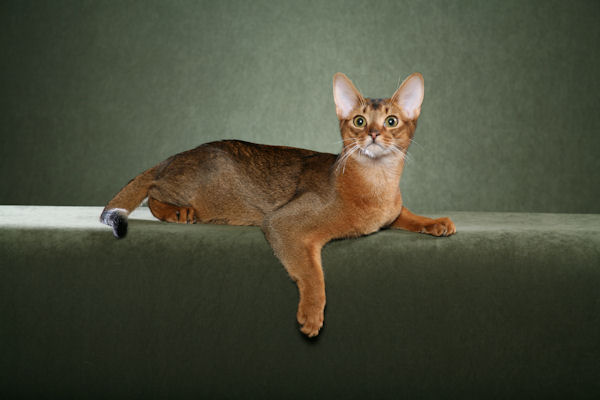

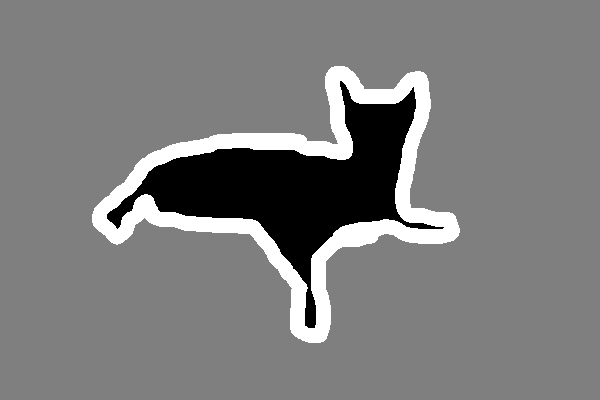

[0 1 2]


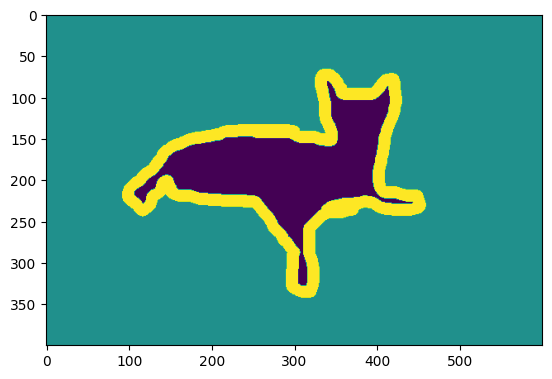

In [ ]:
# Display input image #7
display(Image(filename=input_img_paths[0]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = PIL.ImageOps.autocontrast(load_img(target_img_paths[0]))
display(img)
a = cv2.imread(target_img_paths[0])-1
print(np.unique(a))

plt.imshow(a[:,:,0])

We will now read our images, and build two different sets of data:
1. Training set;
2. Testing set.

The training set will be further divided into training and validation, with a hold-out approach. 

In [44]:

x = np.zeros((500,128,128,3), dtype="float32")
y = np.zeros((500,128,128,3), dtype="int32")

for j in range(0,500):
  img = cv2.imread(input_img_paths[j])
  img2 = cv2.imread(target_img_paths[j])
  try:
    img = cv2.resize(img,(128,128))
    img2=cv2.resize(img2,(128,128))
    x[j] = img
    y[j] = img2
  except:
    print('a')

x_test = np.zeros((50,128,128,3), dtype="float32")
y_test = np.zeros((50,128,128,3), dtype="int32")

for j in range(500,550):
  img = cv2.imread(input_img_paths[j])
  img2 = cv2.imread(target_img_paths[j])
  try:
    img = cv2.resize(img,(128,128))
    img2=cv2.resize(img2,(128,128))
    x_test[j-500] = img
    y_test[j-500] = img2
  except:
    print('a')

y = y[:,:,:,0]-1
y = keras.utils.to_categorical(y,3)
y_test = y_test[:,:,:,0]-1
y_test = keras.utils.to_categorical(y_test,3)

a


In [39]:
# Split the dataset into Training and Validation
test_size = 0.2
random_state = 1

# Normalize the data to [0, 1]

x_train,x_val,y_train,y_val = train_test_split(x,y,test_size= test_size,random_state = random_state)

x_train=x_train/255
x_val=x_val/255


## Building U-Net from Scratch


Write the code to implement (from scratch) a Unet architecture, and evaluate it on the Oxford-IIIT pet dataset.

*   First, build a function doubel_conv_block(x, n_filters) that builds two convolutional layers, with n_filters. 
* Let's use a filter size 3x3



In [8]:
def double_conv_block(x, n_filters):
  #code here

  x = layers.Conv2D(n_filters,3,padding = 'same')(x)
  y = layers.Conv2D(n_filters,3,padding = 'same')(x)

  return y



*   Now, we define a function down_sample_block(x) that performs one step of our Unet:
1. Two convolutional layers (use function built in previous point)
2. Max pooling;



In [16]:
def downsample_block(x, n_filters):
   #code here

   f = double_conv_block(x,n_filters)
   p = layers.MaxPooling2D(2)(f)

   return f,p

It is now the moment of the Up-Sample blocks

First, build a function conv_trans_block, that performs a Transpose Convolution:


*   Let's use kernel of size 3, and stride of 2 (we want to double the size of our features)



In [10]:
def conv_trans_block(x, n_filters):
  # code here
  
  x = layers.Conv2DTranspose(n_filters,3,2,padding = 'same')(x)

  return x

  

    



*   Write a function upsample_block(x,features,filters), where features is the input you want to merge as in the Unet architecture.
* use layers.concatenate to merge features and the current map 



In [11]:
def upsample_block(x, conv_features, n_filters):
   #code here

   x = conv_trans_block(x,n_filters)
   y = layers.concatenate([x,conv_features])
   y = layers.Dropout(0.3)(y)
   z = double_conv_block(y,n_filters)

   return z

Now we build the Unet, following the original architecture

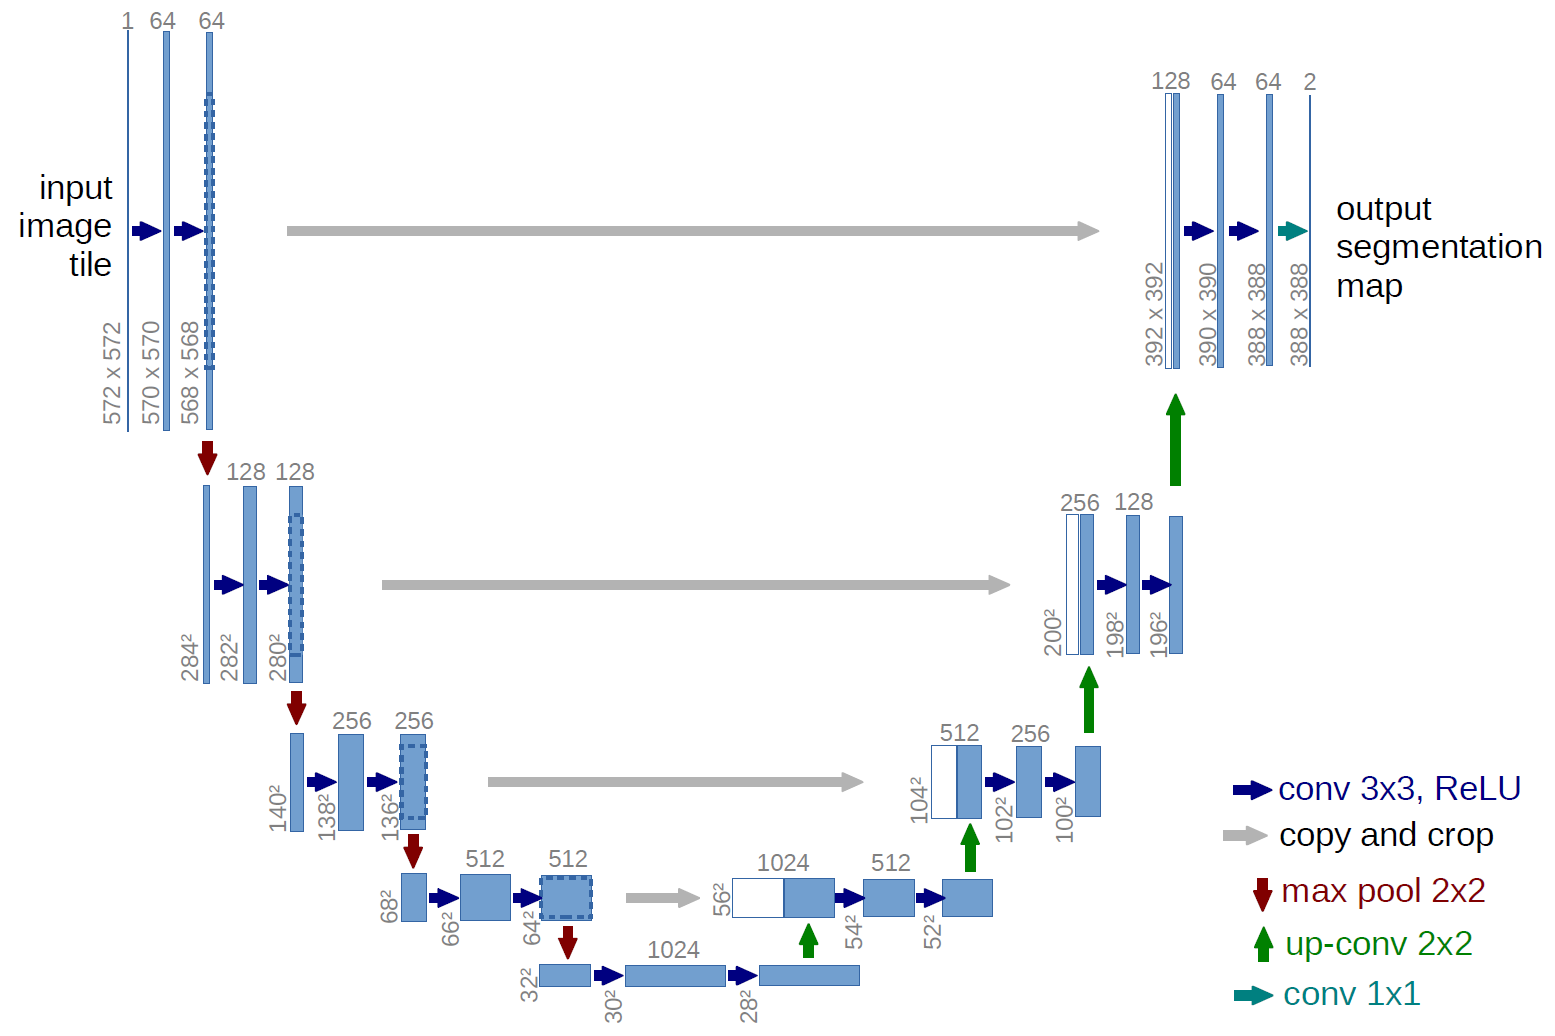

In [19]:
def Unet():
   # inputs
   inputs = layers.Input(shape=(128,128,3))
   # encoder: contracting path - downsample
   
   #code here

   f1,p1=downsample_block(inputs,64)
   f2,p2=downsample_block(p1,128)
   f3,p3=downsample_block(p2,256)
   f4,p4=downsample_block(p3,512) 

   # 5 - bottleneck
   #code here

   bottleneck = double_conv_block(p4,1024)

   # decoder: expanding path - upsample
   # code here 
   x1=upsample_block(bottleneck,f4,512)
   x2=upsample_block(x1,f3,256)
   x3=upsample_block(x2,f2,128)
   x4=upsample_block(x3,f1,64)
   
   # outputs
   outputs = layers.Conv2D(3, 1,  activation = "softmax")(x4)
   # unet model with Keras Functional API
   unet_model = keras.Model(inputs, outputs, name="U-Net")
   return unet_model

Now we compile the model with segmentation_models categorical cross entropy, adam optimizer and accuracy as metrics. 

help: loss=sm.losses.categorical_crossentropy for the loss

In [40]:
# Create model instance

# Compile the model


model = Unet()

model.compile(loss=sm.losses.categorical_crossentropy,metrics='accuracy',optimizer = 'adam')


Finally, we train our model 

In [41]:

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 10 #choose one value


#code for model training

model.fit(
    x=x_train,
    y=y_train,
    batch_size=20,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=callbacks
)


Epoch 1/10
28/28 [==============================] - 17s 568ms/step - loss: 2.1847 - accuracy: 0.5222 - val_loss: 2.3190 - val_accuracy: 0.5684
Epoch 2/10
28/28 [==============================] - 10s 354ms/step - loss: 2.2782 - accuracy: 0.5760 - val_loss: 2.3190 - val_accuracy: 0.5684
Epoch 3/10
28/28 [==============================] - 10s 358ms/step - loss: 2.2782 - accuracy: 0.5760 - val_loss: 2.3190 - val_accuracy: 0.5684
Epoch 4/10
28/28 [==============================] - 10s 343ms/step - loss: 2.2782 - accuracy: 0.5760 - val_loss: 2.3190 - val_accuracy: 0.5684
Epoch 5/10
28/28 [==============================] - 10s 361ms/step - loss: 2.2782 - accuracy: 0.5760 - val_loss: 2.3190 - val_accuracy: 0.5684
Epoch 6/10
28/28 [==============================] - 10s 344ms/step - loss: 2.2782 - accuracy: 0.5760 - val_loss: 2.3190 - val_accuracy: 0.5684
Epoch 7/10
28/28 [==============================] - 9s 336ms/step - loss: 2.2782 - accuracy: 0.5760 - val_loss: 2.3190 - val_accuracy: 0.5684


Let us visualize few of our predictions. Try a bunch of images in the test set.

2/2 [==============================] - 0s 184ms/step


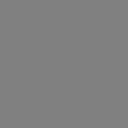

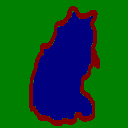

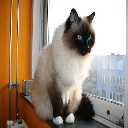

[1]


In [42]:
# val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(x_test/255.0)
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    cv2_imshow(mask*128)
    cv2_imshow(y_test[i]*128)
    cv2_imshow(x_test[i])
    print(np.unique(mask))
# Display results for validation image #10
i = 0
# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.

## Using the Segmentation_Models Library

Let us try a pre-trained model, which is available in the library segmentation_models. 
- Comments on the results. 
  - Does the performances improve? 
  - Why do you think this is happening?

In [49]:
encoder =  "resnet50" # Choose a segmentation_models encoder

# Create the model, and initialize with ImageNet weights

model = sm.Linknet(backbone_name=encoder , encoder_weights = "imagenet")


# Compile the model

model.compile(loss=sm.losses.categorical_crossentropy,metrics='accuracy',optimizer = 'adam')


94592056/94592056 [==============================] - 1s 0us/step


In [50]:
# Train the model, similar to the previous strategy

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 10 #choose one value


#code for model training

model.fit(
    x=x_train,
    y=y_train,
    batch_size=20,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=callbacks
)


Epoch 1/10
28/28 [==============================] - 22s 404ms/step - loss: 3.9736e-08 - accuracy: 0.5902 - val_loss: 3.9736e-08 - val_accuracy: 0.6662
Epoch 2/10
28/28 [==============================] - 4s 137ms/step - loss: 3.9736e-08 - accuracy: 0.5902 - val_loss: 3.9736e-08 - val_accuracy: 0.6625
Epoch 3/10
28/28 [==============================] - 4s 137ms/step - loss: 3.9736e-08 - accuracy: 0.5899 - val_loss: 3.9736e-08 - val_accuracy: 0.6518
Epoch 4/10
28/28 [==============================] - 4s 141ms/step - loss: 3.9736e-08 - accuracy: 0.5902 - val_loss: 3.9736e-08 - val_accuracy: 0.6361
Epoch 5/10
28/28 [==============================] - 4s 153ms/step - loss: 3.9736e-08 - accuracy: 0.5903 - val_loss: 3.9736e-08 - val_accuracy: 0.6261
Epoch 6/10
28/28 [==============================] - 4s 138ms/step - loss: 3.9736e-08 - accuracy: 0.5900 - val_loss: 3.9736e-08 - val_accuracy: 0.6176
Epoch 7/10
28/28 [==============================] - 4s 141ms/step - loss: 3.9736e-08 - accuracy: 0.

2/2 [==============================] - 4s 922ms/step


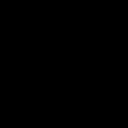

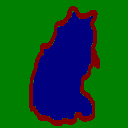

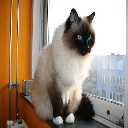

[0]


In [51]:
# val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(x_test/255.0)
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    cv2_imshow(mask*128)
    cv2_imshow(y_test[i]*128)
    cv2_imshow(x_test[i])
    print(np.unique(mask))
# Display results for validation image #10
i = 0
# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.

## Try to change few parameters in our defined Unet:

- add a dropout (after maxpooling) to the downsample block;
- Use more images for training;
- Change the learning rate;
- Change the optimizer. 
Comments on how the results change. 
If you want, you can change the metrics to IoU.

When we use more images for training the execution item increase drastically and no big differences were noted

Different learning rate

In [30]:
model = Unet()
opt = tf.keras.optimizers.experimental.Adam(learning_rate=0.9)


model.compile(loss=sm.losses.categorical_crossentropy,metrics='accuracy',optimizer = opt)

In [31]:
callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 10 #choose one value


#code for model training

model.fit(
    x=x_train,
    y=y_train,
    batch_size=20,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=callbacks
)

Epoch 1/10
20/20 [==============================] - 14s 328ms/step - loss: nan - accuracy: 0.2935 - val_loss: nan - val_accuracy: 0.2799
Epoch 2/10
20/20 [==============================] - 6s 318ms/step - loss: nan - accuracy: 0.2908 - val_loss: nan - val_accuracy: 0.2799
Epoch 3/10
20/20 [==============================] - 6s 312ms/step - loss: nan - accuracy: 0.2908 - val_loss: nan - val_accuracy: 0.2799
Epoch 4/10
20/20 [==============================] - 6s 323ms/step - loss: nan - accuracy: 0.2908 - val_loss: nan - val_accuracy: 0.2799
Epoch 5/10
20/20 [==============================] - 6s 325ms/step - loss: nan - accuracy: 0.2908 - val_loss: nan - val_accuracy: 0.2799
Epoch 6/10
20/20 [==============================] - 6s 315ms/step - loss: nan - accuracy: 0.2908 - val_loss: nan - val_accuracy: 0.2799
Epoch 7/10
20/20 [==============================] - 6s 315ms/step - loss: nan - accuracy: 0.2908 - val_loss: nan - val_accuracy: 0.2799
Epoch 8/10
20/20 [=============================

2/2 [==============================] - 0s 173ms/step


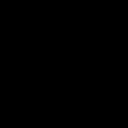

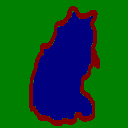

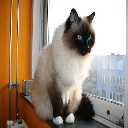

[0]


In [33]:
# val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(x_test/255.0)
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    cv2_imshow(mask*128)
    cv2_imshow(y_test[i]*128)
    cv2_imshow(x_test[i])
    print(np.unique(mask))
# Display results for validation image #10
i = 0
# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.

Different Optimizer

In [24]:
model = Unet()
opt = tf.keras.optimizers.experimental.Adam(learning_rate=0.3)


model.compile(loss=sm.losses.categorical_crossentropy,metrics='accuracy',optimizer = 'SGD')


In [25]:
callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 10 #choose one value


#code for model training

model.fit(
    x=x_train,
    y=y_train,
    batch_size=20,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=callbacks
)

Epoch 1/10
20/20 [==============================] - 9s 394ms/step - loss: 0.3273 - accuracy: 0.5354 - val_loss: 0.3129 - val_accuracy: 0.6035
Epoch 2/10
20/20 [==============================] - 7s 377ms/step - loss: 0.3170 - accuracy: 0.5880 - val_loss: 0.3112 - val_accuracy: 0.6036
Epoch 3/10
20/20 [==============================] - 8s 384ms/step - loss: 0.3157 - accuracy: 0.5885 - val_loss: 0.3101 - val_accuracy: 0.6036
Epoch 4/10
20/20 [==============================] - 8s 382ms/step - loss: 0.3145 - accuracy: 0.5885 - val_loss: 0.3090 - val_accuracy: 0.6036
Epoch 5/10
20/20 [==============================] - 8s 388ms/step - loss: 0.3135 - accuracy: 0.5886 - val_loss: 0.3079 - val_accuracy: 0.6036
Epoch 6/10
20/20 [==============================] - 8s 383ms/step - loss: 0.3123 - accuracy: 0.5884 - val_loss: 0.3069 - val_accuracy: 0.6036
Epoch 7/10
20/20 [==============================] - 7s 374ms/step - loss: 0.3115 - accuracy: 0.5885 - val_loss: 0.3060 - val_accuracy: 0.6035
Epoch 

2/2 [==============================] - 0s 187ms/step


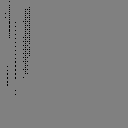

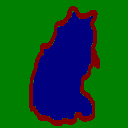

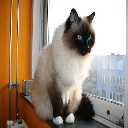

[0 1]


In [26]:
# val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(x_test/255.0)
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    cv2_imshow(mask*128)
    cv2_imshow(y_test[i]*128)
    cv2_imshow(x_test[i])
    print(np.unique(mask))
# Display results for validation image #10
i = 0
# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.